In [35]:
import pandas as pd
import os

### LOAD DATA
umsatz_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv"
wetter_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv"
kiwo_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv"

# Load external data
umsatz_df = pd.read_csv(umsatz_url)
wetter_df = pd.read_csv(wetter_url)
kiwo_df   = pd.read_csv(kiwo_url)
test_df   = pd.read_csv("test.csv",  parse_dates=["Datum"])

umsatz_df['Datum'] = pd.to_datetime(umsatz_df['Datum'])
wetter_df['Datum'] = pd.to_datetime(wetter_df['Datum'])
kiwo_df['Datum'] = pd.to_datetime(kiwo_df['Datum'])

print("Umsatz columns:", umsatz_df.columns.tolist())
print("Wetter columns:", wetter_df.columns.tolist())
print("KiWo columns:", kiwo_df.columns.tolist())


### MERGE DATA
merged_df = pd.concat([umsatz_df, test_df], axis=0, ignore_index=True)
merged_df = pd.merge(merged_df, wetter_df, on="Datum", how="left")
merged_df = pd.merge(merged_df, kiwo_df, on="Datum", how="left")
merged_df = merged_df.sort_values('Datum')

# Umsatz über alle Warengruppen je Tag summieren
sales_daily_df = merged_df.groupby("Datum")["Umsatz"].sum().reset_index()
sales_daily_df = sales_daily_df.rename(columns={"Umsatz": "sales_daily"})
merged_df = pd.merge(merged_df, sales_daily_df, on="Datum", how="left")

print("\nFinal merged dataframe shape:", merged_df.shape)
print("\nFinal columns:", merged_df.columns.tolist())
print("\nFirst few rows:")
print(merged_df.head())


### MISSING VALUE HANDLING''
merged_df = merged_df.set_index("Datum")
merged_df["Temperatur"] = merged_df["Temperatur"].interpolate(method="time")
merged_df["Windgeschwindigkeit"] = merged_df["Windgeschwindigkeit"].interpolate(method="time")
merged_df["Bewoelkung"] = merged_df["Bewoelkung"].interpolate(method="time")
merged_df = merged_df.reset_index()

# Fill missing values for Kieler
merged_df["KielerWoche"] = merged_df["KielerWoche"].fillna(0)

# Fill missing values for Wettercode
merged_df["Wettercode"] = (merged_df["Wettercode"].fillna(method="ffill").fillna(method="bfill"))

# Show the final merged result
print("\nFinal merged dataframe shape:", merged_df.shape)
print("\nFinal columns:", merged_df.columns.tolist())
print("\nFirst few rows:")
print(merged_df.head())

### ADD NEW VARIABLES
import holidays
de_holidays = holidays.Germany(years=range(2012, 2021))
hol_df = pd.DataFrame(list(de_holidays.items()), columns=["Datum", "Feiertag"]).assign(Datum=lambda df: pd.to_datetime(df["Datum"]),is_holiday=1)
merged_df = pd.merge(merged_df, hol_df[['Datum', 'Feiertag']], on="Datum", how="left")
merged_df["Feiertag"] = merged_df["Feiertag"].fillna("Kein Feiertag")

import yfinance as yf1
dax_df = yf1.download("^GDAXI", start="2012-01-01", end="2020-12-31")["Close"]
dax_df = (dax_df.reset_index().rename(columns={'Date': 'Datum','Close': 'DAX_Close'}))
dax_df = dax_df.rename(columns={"^GDAXI": "DAX"})
merged_df = merged_df.merge(dax_df, on="Datum", how="left")
merged_df["DAX"] = (merged_df["DAX"].fillna(method="ffill").fillna(method="bfill"))

from astral import sun
from astral import Observer
obs = Observer(latitude=54.3233, longitude=10.1228)
merged_df['day_length_h'] = merged_df['Datum'].dt.date.apply(lambda d: (sun.sun(observer=obs, date=d, tzinfo=None)['sunset'] - sun.sun(observer=obs, date=d, tzinfo=None)['sunrise']).total_seconds() / 3600)


# Jede Warengruppe wird eine eigene Spalte
merged_df["Warengruppe"] = merged_df["Warengruppe"].astype(int)
merged_df_raw = merged_df.copy()
umsatz_pivot = merged_df.pivot_table(index="Datum", columns="Warengruppe", values="Umsatz", aggfunc="sum")
umsatz_pivot.columns = [f"Warengruppe_{col}" for col in umsatz_pivot.columns]
umsatz_pivot = umsatz_pivot.reset_index()
meta_cols = ["Temperatur", "Windgeschwindigkeit", "Bewoelkung", "Wettercode", "KielerWoche",
             "Feiertag", "DAX", "day_length_h"]
meta_df = merged_df_raw.groupby("Datum")[meta_cols].first().reset_index()
merged_df = pd.merge(umsatz_pivot, meta_df, on="Datum", how="left")
warengruppe_cols = [col for col in merged_df.columns if col.startswith("Warengruppe_")]
merged_df["sales_daily"] = merged_df[warengruppe_cols].sum(axis=1)
merged_df[warengruppe_cols] = merged_df[warengruppe_cols].fillna(0)

merged_df.to_csv("merged_output.csv", index=False)

/tmp/ipykernel_2009/2438350581.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df["Wettercode"] = (merged_df["Wettercode"].fillna(method="ffill").fillna(method="bfill"))
/tmp/ipykernel_2009/2438350581.py:68: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dax_df = yf1.download("^GDAXI", start="2012-01-01", end="2020-12-31")["Close"]
[*********************100%***********************]  1 of 1 completed

Umsatz columns: ['id', 'Datum', 'Warengruppe', 'Umsatz']
Wetter columns: ['Datum', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode']
KiWo columns: ['Datum', 'KielerWoche']

Final merged dataframe shape: (11164, 10)

Final columns: ['id', 'Datum', 'Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 'KielerWoche', 'sales_daily']

First few rows:
        id      Datum  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
0  1307011 2013-07-01            1  148.828353         6.0     17.8375   
1  1307013 2013-07-01            3  201.198426         6.0     17.8375   
2  1307014 2013-07-01            4   65.890169         6.0     17.8375   
3  1307015 2013-07-01            5  317.475875         6.0     17.8375   
4  1307012 2013-07-01            2  535.856285         6.0     17.8375   

   Windgeschwindigkeit  Wettercode  KielerWoche  sales_daily  
0                 15.0        20.0          NaN  1269.249107  
1                 15.0        


/tmp/ipykernel_2009/2438350581.py:72: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df["DAX"] = (merged_df["DAX"].fillna(method="ffill").fillna(method="bfill"))


In [10]:
# dieser code ghier soll die basic infos von wetter_df printen
print(wetter_df.head())  # Print first few rows to verify
print(wetter_df.info())  # Print info about the DataFrame
print(wetter_df.describe())  # Print descriptive statistics

# find values in wetter_df which have missing values or NaN
missing_values = wetter_df.isnull().sum()
print("\nMissing values in wetter_df:")
print(missing_values[missing_values > 0])  # Only print columns with missing values

# for all missing values take the value from the previous day
wetter_df.fillna(method='ffill', inplace=True)
print(wetter_df.head())  # Print first few rows to verify

       Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
0 2012-01-01         8.0      9.8250                   14        58.0
1 2012-01-02         7.0      7.4375                   12         NaN
2 2012-01-03         8.0      5.5375                   18        63.0
3 2012-01-04         4.0      5.6875                   19        80.0
4 2012-01-05         6.0      5.3000                   23        80.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2601 entries, 0 to 2600
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                2601 non-null   datetime64[ns]
 1   Bewoelkung           2591 non-null   float64       
 2   Temperatur           2601 non-null   float64       
 3   Windgeschwindigkeit  2601 non-null   int64         
 4   Wettercode           1932 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 101.7 KB
None

/tmp/ipykernel_4492/2195552814.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wetter_df.fillna(method='ffill', inplace=True)


In [37]:
import pandas as pd
from datetime import datetime

# 1. Einlesen
df = pd.read_csv("merged_output.csv")

# 2. Datum parsen und sortieren
df['Datum'] = pd.to_datetime(df['Datum'], errors='coerce')
df = df.sort_values('Datum')

# 3. Übersicht der Spalten
print("Spaltenübersicht:", df.columns.tolist())
print(df.head(3))

print("\nNaN-Übersicht (in %):")
print((df.isna().sum() / len(df) * 100).round(1).sort_values(ascending=False))

# 4. Nur Zeilen mit Umsatz behalten (Training only!)
df = df[df['sales_daily'].notna()].copy()

df['Wochentag'] = df['Datum'].dt.dayofweek  # 0 = Montag, 6 = Sonntag
df['Wochenende'] = df['Wochentag'].isin([5,6]).astype(int)

train_start = datetime(2013, 7, 1)
train_end = datetime(2017, 7, 31)
val_start = datetime(2017, 8, 1)
val_end = datetime(2018, 7, 31)
test_start = datetime(2018, 8, 1)
test_end = datetime(2019, 7, 31)

# Jetzt filtern
train_set = df[(df['Datum'] >= train_start) & (df['Datum'] <= train_end)].copy()
val_set   = df[(df['Datum'] >= val_start)   & (df['Datum'] <= val_end)].copy()
test_set  = df[(df['Datum'] >= test_start)  & (df['Datum'] <= test_end)].copy()

Spaltenübersicht: ['Datum', 'Warengruppe_1', 'Warengruppe_2', 'Warengruppe_3', 'Warengruppe_4', 'Warengruppe_5', 'Warengruppe_6', 'Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode', 'KielerWoche', 'Feiertag', 'DAX', 'day_length_h', 'sales_daily']
       Datum  Warengruppe_1  Warengruppe_2  Warengruppe_3  Warengruppe_4  \
0 2013-07-01     148.828353     535.856285     201.198426      65.890169   
1 2013-07-02     159.793757     546.780787     265.261254      74.543917   
2 2013-07-03     111.885594     427.343259     210.260241      69.262728   

   Warengruppe_5  Warengruppe_6  Temperatur  Windgeschwindigkeit  Bewoelkung  \
0     317.475875            0.0     17.8375                 15.0         6.0   
1     383.628682            0.0     17.3125                 10.0         3.0   
2     305.523072            0.0     21.0750                  6.0         7.0   

   Wettercode  KielerWoche       Feiertag          DAX  day_length_h  \
0        20.0          0.0  Kein Feiertag 

In [38]:
import pandas as pd
from datetime import datetime

# Load the merged dataset from the first script
merged_df = pd.read_csv("merged_output.csv")

# Convert Datum column to datetime if not already done
merged_df['Datum'] = pd.to_datetime(merged_df['Datum'])

# Define date ranges for splitting
train_start = datetime(2013, 7, 1)
train_end = datetime(2017, 7, 31)
val_start = datetime(2017, 8, 1)
val_end = datetime(2018, 7, 31)
test_start = datetime(2018, 8, 1)
test_end = datetime(2019, 7, 31)

# Split the dataset based on date ranges
train_set = merged_df[(merged_df['Datum'] >= train_start) & 
                      (merged_df['Datum'] <= train_end)].copy()

validation_set = merged_df[(merged_df['Datum'] >= val_start) & 
                          (merged_df['Datum'] <= val_end)].copy()

test_set = merged_df[(merged_df['Datum'] >= test_start) & 
                     (merged_df['Datum'] <= test_end)].copy()

# Save the split datasets
train_set.to_csv("train_set.csv", index=False)
validation_set.to_csv("validation_set.csv", index=False)
test_set.to_csv("test_set.csv", index=False)

# Display first few rows of each set for verification
print("\n" + "="*50)
print("TRAINING SET - First 5 rows:")
print(train_set.head())

print("\n" + "="*50)
print("VALIDATION SET - First 5 rows:")
print(validation_set.head())

print("\n" + "="*50)
print("TEST SET - First 5 rows:")
print(test_set.head())

# Optional: Display some statistics about each dataset
print("\n" + "="*50)
print("DATASET STATISTICS:")
print("\nTraining Set Statistics:")
print(train_set.describe())

print("\nValidation Set Statistics:")
print(validation_set.describe())

print("\nTest Set Statistics:")
print(test_set.describe())


TRAINING SET - First 5 rows:
       Datum  Warengruppe_1  Warengruppe_2  Warengruppe_3  Warengruppe_4  \
0 2013-07-01     148.828353     535.856285     201.198426      65.890169   
1 2013-07-02     159.793757     546.780787     265.261254      74.543917   
2 2013-07-03     111.885594     427.343259     210.260241      69.262728   
3 2013-07-04     168.864941     454.859641     190.686641      61.490175   
4 2013-07-05     171.280754     492.818804     181.644870      86.759861   

   Warengruppe_5  Warengruppe_6  Temperatur  Windgeschwindigkeit  Bewoelkung  \
0     317.475875            0.0     17.8375                 15.0         6.0   
1     383.628682            0.0     17.3125                 10.0         3.0   
2     305.523072            0.0     21.0750                  6.0         7.0   
3     308.408168            0.0     18.8500                  7.0         7.0   
4     355.518770            0.0     19.9750                 12.0         5.0   

   Wettercode  KielerWoche      


VALIDIERUNG:
MSE: 4.965328300579821e-25
R² : 1.0

TEST:
MSE: 3.1102282292772907e-24
R² : 0.0


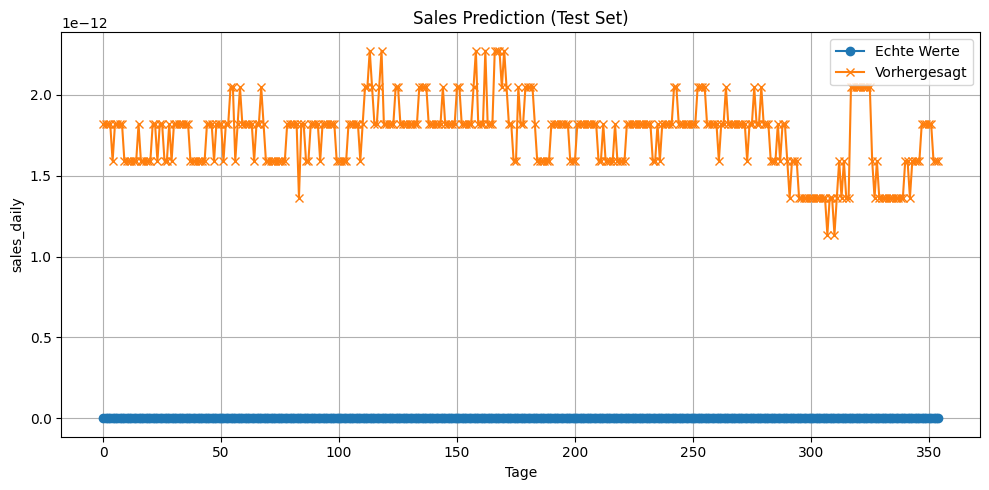

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

train_set = pd.read_csv("train_set.csv")
validation_set = pd.read_csv("validation_set.csv")
test_set = pd.read_csv("test_set.csv")

# Spalten, die als Eingabe verwendet werden sollen (alle außer Datum & Zielspalte)
exclude_cols = ['Datum', 'Feiertag']  # 'Feiertag' ist nicht numerisch
feature_cols = [col for col in train_set.columns if col not in exclude_cols]

# Zielvariable
target_col = 'sales_daily'

# Features & Targets vorbereiten
X_train = train_set[feature_cols]
y_train = train_set[target_col]

X_val = validation_set[feature_cols]
y_val = validation_set[target_col]

X_test = test_set[feature_cols]
y_test = test_set[target_col]

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Vorhersagen
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Bewertung
print("\nVALIDIERUNG:")
print("MSE:", mean_squared_error(y_val, y_val_pred))
print("R² :", r2_score(y_val, y_val_pred))

print("\nTEST:")
print("MSE:", mean_squared_error(y_test, y_test_pred))
print("R² :", r2_score(y_test, y_test_pred))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Echte Werte', marker='o')
plt.plot(y_test_pred, label='Vorhergesagt', marker='x')
plt.title("Sales Prediction (Test Set)")
plt.xlabel("Tage")
plt.ylabel("sales_daily")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()